# Text Sentiment Classification with a Neural Net

This example is from: https://pythonprogramming.net/using-our-own-data-tensorflow-deep-learning-tutorial/?completed=/tensorflow-neural-network-session-machine-learning-tutorial/

The positive data has ~5000 positive sentiment statements and negative data has about ~5000 negative sentiment statments. We will train a classifier on this data in hopes that it can learn to identify the sentiment of statments.  
Here is an example of the data:  
> if you sometimes like to go to the movies to have fun , wasabi is a good place to start .   
> emerges as something rare , an issue movie that's so honest and keenly observed that it doesn't feel like one .   
> the film provides some great insight into the neurotic mindset of all comics -- even those who have reached the absolute top of the game .   

As we can see, not all sentences are the same length, so it will be trickey to convert sentences into a vector of features to input into the model.  
We will rely on a classic bag-of-words technique where we create a vector of unique key-words [movies, fun, wasabi, comics].
Then, for each sentence, we encode the sentence as a vector of 0s the length of the key-words list [0, 0, 0, 0] and replace those 0s with 1s at the index of any key-word that shows up in the sentence [1, 1, 1, 0] (for sentence 1 above).

We will use the Natural Language Toolkit module. The tokenizer separates words and the lemmatizer takes similair words and converts them into the same words, reducing the overall number (e.g., studies, studying, & studied -> study).  


In [154]:
#nltk.download()
import numpy as np
import random
import pickle
## for nlp
import nltk
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
## for deep learning
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

# Data Pre-Processing

In [3]:
lemmatizer = WordNetLemmatizer()
hm_lines = 100000 ##how many lines to process? this will include all ~10,000

To create the lexicon we open each file, read the lines of the file, and then for each line we tokenize to break apart the words, and add each word to the lexicon.
Next, we lemmatize the lexicon with the lemmatizer.
Then, we count the number of time each word appears, so we can remove super repeating words, or very uncommon ones.

In [94]:
def create_lexicon(pos, neg):
    """

    """
    lexicon = []
    with open(pos, 'r') as f:
        contents = f.readlines()
        for line in contents[:hm_lines] :
            all_words = word_tokenize(line)
            lexicon += list(all_words)

    with open(neg, 'r') as f:
        contents = f.readlines()
        for line in contents[:hm_lines] :
            all_words = word_tokenize(line)
            lexicon += list(all_words)

    lexicon = [lemmatizer.lemmatize(i) for i in lexicon]
    word_counts = Counter(lexicon)

    l2 = []
    for w in word_counts:
        #prop = word_counts[w] / sum(word_counts)
        if 50 < word_counts[w] < 1000 :
        #if 0.1 < prop < 0.7:
            l2.append(w)
    print("Length of lexicon: ", len(l2))
    return l2

In [95]:
pos = 'data/pos.txt'
neg = 'data/neg.txt'
create_lexicon(pos, neg)

Length of lexicon:  423


['be',
 'new',
 '``',
 'he',
 'going',
 'make',
 'even',
 'than',
 'or',
 'so',
 'can',
 'not',
 'if',
 'sometimes',
 'like',
 'go',
 'have',
 'fun',
 'good',
 'place',
 'start',
 'something',
 'rare',
 'doe',
 "n't",
 'feel',
 'one',
 'some',
 'great',
 'into',
 'all',
 'comic',
 '--',
 'those',
 'who',
 'game',
 'offer',
 'entertainment',
 'no',
 'picture',
 'ever',
 'made',
 'ha',
 'more',
 'turn',
 'screenplay',
 'at',
 ';',
 'clever',
 'want',
 'off',
 'take',
 'care',
 'my',
 'cinema',
 'well',
 'worth',
 'what',
 'really',
 'surprise',
 'about',
 '(',
 ')',
 'why',
 'we',
 ':',
 'through',
 'eye',
 'heart',
 'mind',
 'ultimately',
 'reason',
 'need',
 'story',
 'much',
 'compelling',
 "'",
 'which',
 'most',
 'come',
 'documentary',
 'year',
 'making',
 'will',
 'fresh',
 'true',
 'cast',
 'actor',
 'u',
 'because',
 'amusing',
 'how',
 'our',
 'life',
 'music',
 'by',
 'everyone',
 'from',
 'few',
 'point',
 'also',
 'love',
 'out',
 'romantic',
 'minute',
 'familiar',
 'lack',

Now, we need to create a function to process each line for the bag-of-words model. Again, we need a vector of 0s of length lexicon, and the index of each word in the lexicon is "activated" (turned from 0 to 1) if that word appears in the sentence.
The function below needs to read in the raw lines of text and then check the words with the lexicon.

In [118]:
def sample_handling(sample, lexicon, label):
    featureset = []

    with open(sample, 'r') as f:
        contents = f.readlines()
        for l in contents[:hm_lines] :
            current_words = word_tokenize(l.lower()) ##convert all letters to lowercase and tokenize the line
            current_words = [lemmatizer.lemmatize(i) for i  in current_words] ##lemmatize the line to group similair words (necessary to match lexicon also)
            features = np.zeros(len(lexicon)) ##the vector of 0s length lexicon
            for word in current_words:  ##for each word, check if it's in lexicon and if it is, find its index and activate index of zero vector
                if word.lower() in lexicon:
                    index_value = lexicon.index(word.lower())
                    features[index_value] += 1

            features = list(features)
            featureset.append([features, label])
                        
    return featureset

We can write an additional fn to break up the lexicon into a training and testing split.

In [173]:
def create_featuresets_and_lexicon(pos, neg, test_size=0.1):
    lexicon = create_lexicon(pos, neg)
    features = []
    features += sample_handling(sample=pos, lexicon=lexicon, label=[1,0]) ##one-hot encoded labels
    features += sample_handling(sample=neg, lexicon=lexicon, label=[0,1])
    random.shuffle(features) ##randomly sort the pos and neg lines

    testing_size = int(test_size*len(features))        ## break features into train/test split

    train_x = [f[0] for f in features[:-testing_size]] #list(features[:,0][:-testing_size])
    train_y = [f[1] for f in features[:-testing_size]] #list(features[:,1][:-testing_size])
    test_x = [f[0] for f in features[-testing_size:]] #list(features[:,0][-testing_size:])
    test_y = [f[1] for f in features[-testing_size:]] #list(features[:,1][-testing_size:])

    return train_x, train_y, test_x, test_y

In [174]:
## CREATE FINAL DATA
train_x, train_y, test_x, test_y = create_featuresets_and_lexicon(pos='data/pos.txt', neg='data/neg.txt')

#pickle the data if desired
#with open('data/sentiment_set.pickle', 'wb') as f:
#    pickle.dump([train_x, train_y, test_x, test_y],f)

Length of lexicon:  423


In [175]:
train_x, train_y, test_x, test_y = np.array(train_x), np.array(train_y), np.array(test_x), np.array(test_y)
print("X", train_x.shape)
print("y", train_y.shape)

X (9596, 423)
y (9596, 2)


# Model

In [142]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(423,)),
    ## 3 hidden layers
    tf.keras.layers.Dense(1280, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(768, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(384, activation='relu'),
    ## output layer (2 classes)
    tf.keras.layers.Dense(2, activation='softmax'),
])
##(save weights so they can be reset easily)
weights = model.get_weights()
reset_model = lambda model: model.set_weights(weights) ##lambda fn to reset model weights to randomly initialized

optim = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)
model.compile(loss=loss_fn,
              optimizer=optim,
              metrics=['accuracy'])

In [143]:
reset_model(model) ##reset weights back to randomly initialized state
history = model.fit(train_x, train_y, epochs=10, batch_size=100)

Epoch 1/10
96/96 [==============================] - 2s 15ms/step - loss: 0.6311 - accuracy: 0.6404
Epoch 2/10
96/96 [==============================] - 1s 14ms/step - loss: 0.5354 - accuracy: 0.7253
Epoch 3/10
96/96 [==============================] - 1s 14ms/step - loss: 0.4560 - accuracy: 0.7748
Epoch 4/10
96/96 [==============================] - 1s 14ms/step - loss: 0.3194 - accuracy: 0.8509
Epoch 5/10
96/96 [==============================] - 1s 14ms/step - loss: 0.2106 - accuracy: 0.9055
Epoch 6/10
96/96 [==============================] - 1s 15ms/step - loss: 0.1529 - accuracy: 0.9276
Epoch 7/10
96/96 [==============================] - 1s 15ms/step - loss: 0.1408 - accuracy: 0.9336
Epoch 8/10
96/96 [==============================] - 1s 15ms/step - loss: 0.1183 - accuracy: 0.9439
Epoch 9/10
96/96 [==============================] - 1s 15ms/step - loss: 0.1008 - accuracy: 0.9512
Epoch 10/10
96/96 [==============================] - 1s 15ms/step - loss: 0.0981 - accuracy: 0.9514


The model is able to learn the training data quite effectively, but struggles on the test data with only about 66% accuracy. This suggests it's overfitting to the training data.

In [144]:
# Evaluate model
tr_l, tr_a = model.evaluate(train_x, train_y)
te_l, te_a = model.evaluate(test_x, test_y)

print("Training Loss: ", tr_l, "and accuracy: ", tr_a)
print("Test loss: ", te_l, "and accuracy: ", te_a)

34/34 [==============================] - 0s 4ms/step - loss: 1.5663 - accuracy: 0.6773
Training Loss:  0.0700506865978241 and accuracy:  0.9637348651885986
Test loss:  1.5662916898727417 and accuracy:  0.6772983074188232


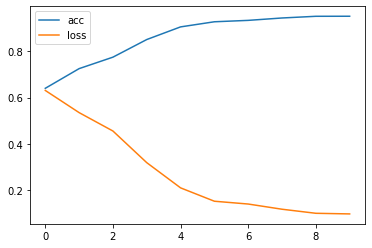

In [145]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.legend(['acc', 'loss'], loc="upper left")
plt.show()

In [163]:
for e in pred_x:
    if e[0]==1:
        print(e)

[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0

In [172]:
lexicon

['be',
 'new',
 '``',
 'he',
 'going',
 'make',
 'even',
 'than',
 'or',
 'so',
 'can',
 'not',
 'if',
 'sometimes',
 'like',
 'go',
 'have',
 'fun',
 'good',
 'place',
 'start',
 'something',
 'rare',
 'doe',
 "n't",
 'feel',
 'one',
 'some',
 'great',
 'into',
 'all',
 'comic',
 '--',
 'those',
 'who',
 'game',
 'offer',
 'entertainment',
 'no',
 'picture',
 'ever',
 'made',
 'ha',
 'more',
 'turn',
 'screenplay',
 'at',
 ';',
 'clever',
 'want',
 'off',
 'take',
 'care',
 'my',
 'cinema',
 'well',
 'worth',
 'what',
 'really',
 'surprise',
 'about',
 '(',
 ')',
 'why',
 'we',
 ':',
 'through',
 'eye',
 'heart',
 'mind',
 'ultimately',
 'reason',
 'need',
 'story',
 'much',
 'compelling',
 "'",
 'which',
 'most',
 'come',
 'documentary',
 'year',
 'making',
 'will',
 'fresh',
 'true',
 'cast',
 'actor',
 'u',
 'because',
 'amusing',
 'how',
 'our',
 'life',
 'music',
 'by',
 'everyone',
 'from',
 'few',
 'point',
 'also',
 'love',
 'out',
 'romantic',
 'minute',
 'familiar',
 'lack',

In [213]:
pred_x = (model.predict(test_x) > 0.5).astype(int)

results = []
for i in range(0, len(pred_x)):
    if pred_x[i][0] == 1:
        pred = "positive"
    else:
        pred = "negative"
    if test_x[i][0] == 1:
        true = "positive"
    else:
        true = "negative"
    results.append([pred, true])

    train_x[i]

#print("Accuracy: ", np.mean(results[0]==true[0]))

results
#[r[0] for r in results] 
#r[1] for r in results]

#print("Predicted, Actual \n", results)


34/34 [==============================] - 0s 5ms/step


[['positive', 'negative'],
 ['positive', 'negative'],
 ['negative', 'negative'],
 ['negative', 'negative'],
 ['positive', 'negative'],
 ['positive', 'negative'],
 ['negative', 'negative'],
 ['negative', 'negative'],
 ['positive', 'negative'],
 ['positive', 'negative'],
 ['negative', 'negative'],
 ['negative', 'negative'],
 ['negative', 'negative'],
 ['positive', 'negative'],
 ['negative', 'negative'],
 ['positive', 'negative'],
 ['positive', 'negative'],
 ['positive', 'negative'],
 ['positive', 'negative'],
 ['negative', 'negative'],
 ['negative', 'positive'],
 ['negative', 'negative'],
 ['positive', 'negative'],
 ['positive', 'negative'],
 ['positive', 'negative'],
 ['positive', 'negative'],
 ['negative', 'negative'],
 ['positive', 'negative'],
 ['negative', 'negative'],
 ['negative', 'negative'],
 ['positive', 'negative'],
 ['negative', 'negative'],
 ['negative', 'negative'],
 ['positive', 'negative'],
 ['negative', 'negative'],
 ['negative', 'negative'],
 ['negative', 'negative'],
 